In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ast import literal_eval
import joblib
import sys
sys.path.append("../")

from cfmining.algorithms import MAPOFCEM
from cfmining.criteria import PercentileCalculator, PercentileCriterion, PercentileChangesCriterion, NonDomCriterion
from cfmining.predictors import GeneralClassifier_Shap
from cfmining.action_set import ActionSet
from cfmining.utils import get_data_model

import dice_ml


%load_ext autoreload
%autoreload 2


## German

In [33]:
X_train, Y_train, model, _, individuals = get_data_model("german")
outlier_detection = joblib.load("../models/german/IsolationForest_test.pkl")

In [34]:
action_set = ActionSet(X = X_train)
not_mutable_features = ['Age', 'OwnsHouse', 'isMale', 'JobClassIsSkilled', 'Single', 'ForeignWorker', 'RentsHouse']
mutable_features = [feat for feat in X_train.columns if feat not in not_mutable_features]
continuous_features = ['Age', 'LoanDuration', 'LoanAmount', 'LoanRateAsPercentOfIncome','YearsAtCurrentHome']
for feat in action_set:
    if feat.name in not_mutable_features:
        feat.mutable = False
    if not feat.name in not_mutable_features:
        feat.mutable = True

    #if feat.name == "LoanDuration":
    #    feat.step_size = 6
    #    feat.step_type = "absolute"
    feat.step_direction = 0
    feat.update_grid()
percCalc = PercentileCalculator(action_set = action_set)

In [4]:
def summarize_results(results, outlier_detection = None, display_results = True):
    results["individual"] = results["individual"].apply(literal_eval)
    results["solutions"] = results["solutions"].apply(literal_eval)
    costs = []
    n_changes = []
    outliers = []
    for i in range(len(results)):
        criteria = PercentileCriterion(individuals.iloc[i].values, percCalc)
        solutions = results["solutions"].iloc[i]
        if len(solutions) == 0:
            costs.append(None)
            n_changes.append(None)
            outliers.append(None)
            continue
        costs_ = [criteria.f(s) for s in solutions][0]
        individual = results["individual"].iloc[i]
        if len(individual) == 1:
            individual = individual[0]
        sol0 = results["solutions"].iloc[i][0]
        n_changes_ = sum([1 for i in range(len(individual)) if individual[i] != sol0[i]])

        n_changes.append(n_changes_)
        costs.append(costs_)
        if outlier_detection is not None:
            outliers_ = [outlier_detection.predict(np.array(s)[None, :]) == -1 for s in solutions][0][0]
            outliers.append(outliers_)
        else:
            outliers.append(False)
            
    results["costs"] = costs
    results["outlier"] = outliers
    results["n_changes"] = n_changes

    if display_results:

        print(f"Time: {results['time'].mean():.3f} +- {results['time'].std():.3f}")
        print(f"Costs: {results['costs'].mean():.3f} +- {results['costs'].std():.3f}")
        print(f"Changes: {results['n_changes'].mean():.3f} +- {results['n_changes'].std():.3f}")
        print(f"Outliers: {results['outlier'].mean():.3f}")

        fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (6, 3))
        axs[0].scatter(
            results.sort_values("prob")["prob"],
            results.sort_values("prob")["time"],
        )
        axs[0].set_xlabel("Probability")
        axs[0].set_ylabel("Time (s)")

        axs[1].scatter(
            results.sort_values("prob")["prob"],
            results.sort_values("prob")["costs"],
        )
        axs[1].set_xlabel("Probability")
        axs[1].set_ylabel("Costs")

        plt.tight_layout()
        plt.show()
    else:
        return results

Time: 0.155 +- 0.009
Costs: 0.525 +- 0.273
Changes: 1.629 +- 0.487
Outliers: 0.016


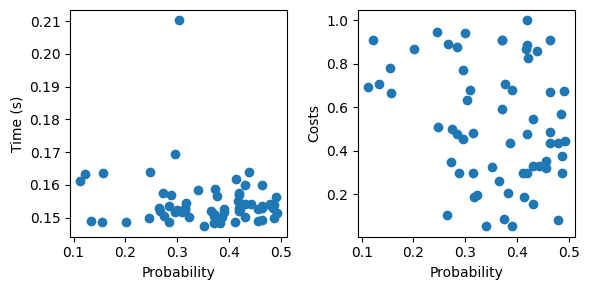

In [5]:
results = pd.read_csv("../results/german/dice_1sol.csv")
summarize_results(results, outlier_detection)

Time: 0.199 +- 0.262
Costs: 0.110 +- 0.078
Changes: 1.855 +- 0.903
Outliers: 0.000


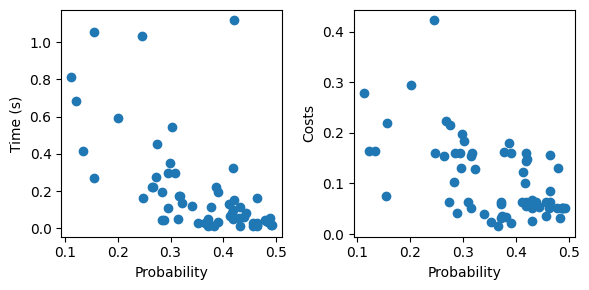

In [36]:
results = pd.read_csv("../results/german/mapofcem_percentile.csv")
summarize_results(results, outlier_detection)

Time: 0.179 +- 0.299
Costs: 0.114 +- 0.115
Changes: 1.517 +- 0.504
Outliers: 0.000


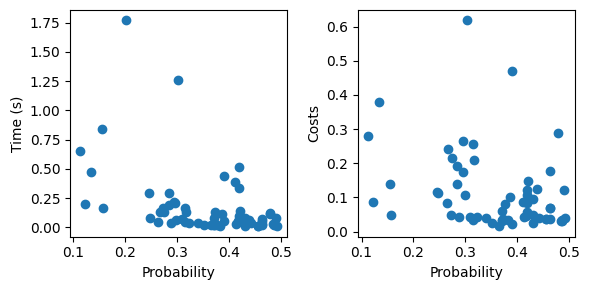

In [27]:
results = pd.read_csv("../results/german/mapofcem_v2_percentile.csv")
summarize_results(results, outlier_detection)

Time: 0.132 +- 0.208
Costs: 0.102 +- 0.078
Changes: 1.903 +- 0.918
Outliers: 0.065


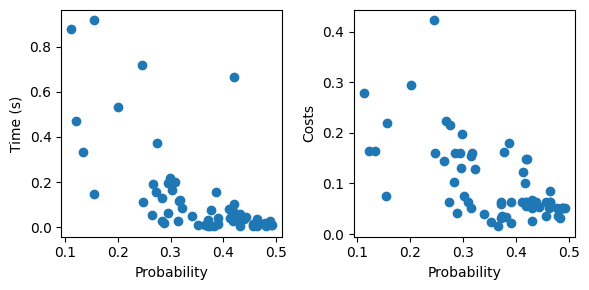

In [59]:
results = pd.read_csv("../results/german/mapocam_percentile.csv")
summarize_results(results, outlier_detection)

Time: 7.377 +- 0.359
Costs: 0.102 +- 0.078
Changes: 1.629 +- 0.794
Outliers: 0.097


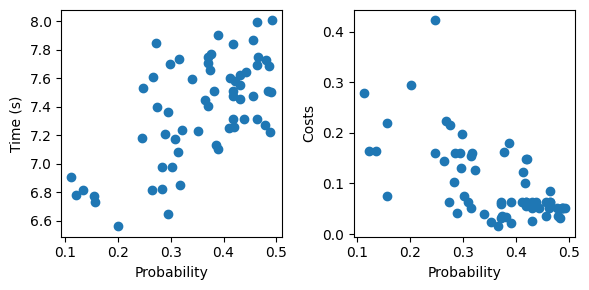

In [60]:
results = pd.read_csv("../results/german/bruteforce_percentiles.csv")
summarize_results(results, outlier_detection)

## Taiwan

In [2]:
X_train, Y_train, model, _, individuals = get_data_model("taiwan")
X_train = X_train.astype(int)
individuals = individuals.astype(int)
outlier_detection = joblib.load("../models/taiwan/IsolationForest_test.pkl")

In [6]:
action_set = ActionSet(X = X_train, default_step_size = 0.1)
not_mutable_features = ['Single', 'Age_in_25_to_40', 'Married', 'Age_lt_25', 'Age_in_40_to_59', 'Age_geq_60', 'EducationLevel']
mutable_features = [feat for feat in X_train.columns if feat not in not_mutable_features]
for feat in action_set:
    if feat.name in not_mutable_features:
        feat.mutable = False
    if feat.name in mutable_features:
        feat.mutable = True

    # if feat.name in [
    #     "MaxBillAmountOverLast6Months", 
    #     "MaxPaymentAmountOverLast6Months", 
    #     "MostRecentBillAmount", 
    #     "MostRecentPaymentAmount"
    # ]:
    #     feat.step_size = 0.1

    feat.step_direction = 0
    feat.update_grid()

percCalc = PercentileCalculator(action_set = action_set)

Time: 0.244 +- 0.150
Costs: 0.591 +- 0.126
Changes: 1.640 +- 0.482
Outliers: 0.000


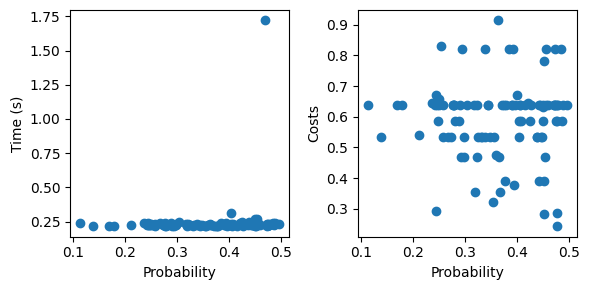

In [7]:
results = pd.read_csv("../results/taiwan/dice_1sol.csv")
summarize_results(results, outlier_detection)

Time: 0.879 +- 1.689
Costs: 0.582 +- 0.132
Changes: 2.200 +- 0.816
Outliers: 0.000


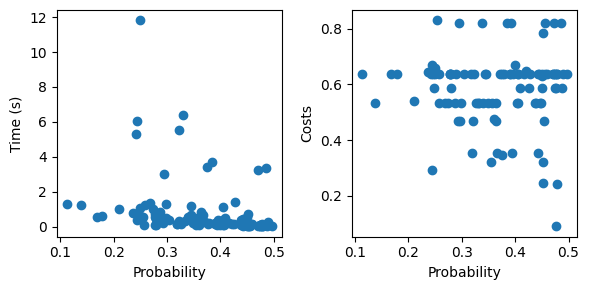

In [8]:
results = pd.read_csv("../results/taiwan/mapofcem_percentile.csv")
summarize_results(results, outlier_detection)

Time: 1.087 +- 1.951
Costs: 0.582 +- 0.132
Changes: 2.200 +- 0.816
Outliers: 0.000


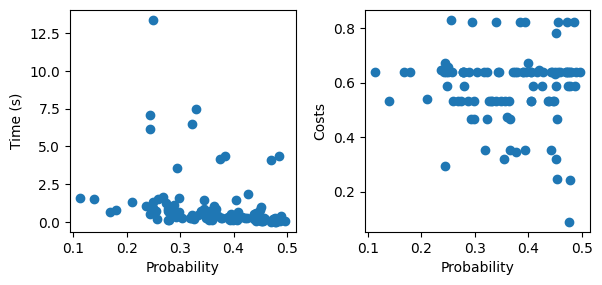

In [9]:
results = pd.read_csv("../results/taiwan/mapofcem_v2_percentile.csv")
summarize_results(results, outlier_detection)

Time: 1.605 +- 4.960
Costs: 0.582 +- 0.132
Changes: 2.200 +- 0.829
Outliers: 0.000


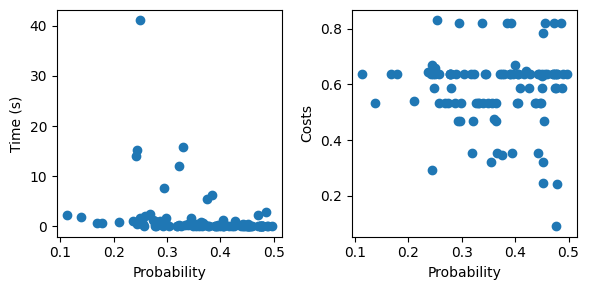

In [10]:
results = pd.read_csv("../results/taiwan/mapocam_percentile.csv")
summarize_results(results, outlier_detection)

Time: 909.372 +- 48.652
Costs: 0.939 +- 0.146
Changes: 1.809 +- 0.851
Outliers: 0.000


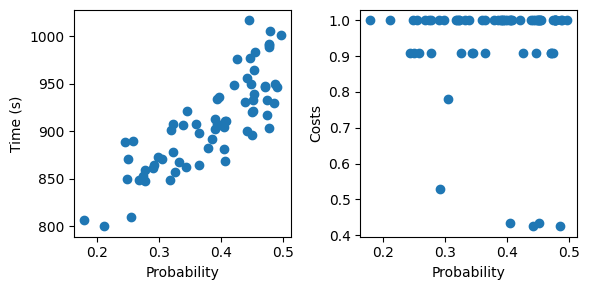

In [66]:
results = pd.read_csv("../results/taiwan/bruteforce_percentile.csv")
summarize_results(results, outlier_detection)

## Step size analysis

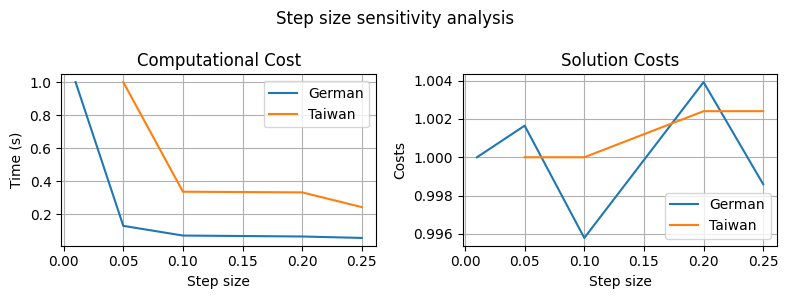

In [33]:
fig, axs  = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 3))

results_dict = []
for s in [1, 5, 10, 20, 25]:
    results = pd.read_csv(f"../results/german_step_size/mapofcem_{s}.csv")
    results = summarize_results(results, display_results=False)

    new_row = {}
    new_row["step_size"] = s/100
    new_row["time"] = results["time"].mean()
    new_row["time_std"] = results["time"].std()
    new_row["costs"] = results["costs"].mean()
    new_row["costs_std"] = results["costs"].std()
    results_dict.append(new_row)

results_dict = pd.DataFrame(results_dict)


# axs[0].fill_between(
#     results_dict["step_size"],
#     (results_dict["time"] - results_dict["time_std"]) / results_dict.time.iloc[0],
#     (results_dict["time"] + results_dict["time_std"]) / results_dict.time.iloc[0],
#     alpha = 0.3,
# )
axs[0].plot(results_dict["step_size"], results_dict["time"] / results_dict.time.iloc[0], label = "German")
axs[0].set_xlabel("Step size")
axs[0].set_ylabel("Time (s)")
#axs[0].set_yscale("log")

# axs[1].fill_between(
#     results_dict["step_size"],
#     (results_dict["costs"] - results_dict["costs_std"]) / results_dict.costs.iloc[0],
#     (results_dict["costs"] + results_dict["costs_std"]) / results_dict.costs.iloc[0],
#     alpha = 0.3,
# )
axs[1].plot(results_dict["step_size"], results_dict["costs"] / results_dict.costs.iloc[0], label = "German")
axs[1].set_xlabel("Step size")
axs[1].set_ylabel("Costs")


results_dict = []
for s in [5, 10, 20, 25]:
    results = pd.read_csv(f"../results/taiwan_step_size/mapofcem_{s}.csv")
    results = summarize_results(results, display_results=False)

    new_row = {}
    new_row["step_size"] = s/100
    new_row["time"] = results["time"].mean()
    new_row["time_std"] = results["time"].std()
    new_row["costs"] = results["costs"].mean()
    new_row["costs_std"] = results["costs"].std()
    results_dict.append(new_row)

results_dict = pd.DataFrame(results_dict)


# axs[0].fill_between(
#     results_dict["step_size"],
#     (results_dict["time"] - results_dict["time_std"]) / results_dict.time.iloc[0],
#     (results_dict["time"] + results_dict["time_std"]) / results_dict.time.iloc[0],
#     alpha = 0.3,
# )
axs[0].plot(results_dict["step_size"], results_dict["time"] / results_dict.time.iloc[0], label = "Taiwan")
axs[0].set_xlabel("Step size")
axs[0].set_ylabel("Time (s)")
#axs[0].set_yscale("log")

# axs[1].fill_between(
#     results_dict["step_size"],
#     (results_dict["costs"] - results_dict["costs_std"]) / results_dict.costs.iloc[0],
#     (results_dict["costs"] + results_dict["costs_std"]) / results_dict.costs.iloc[0],
#     alpha = 0.3,
# )
axs[1].plot(results_dict["step_size"], results_dict["costs"] / results_dict.costs.iloc[0], label = "Taiwan")
axs[1].set_xlabel("Step size")
axs[1].set_ylabel("Costs")


for i in range(2):
    axs[i].legend()
    axs[i].grid()

axs[0].set_title("Computational Cost")
axs[1].set_title("Solution Costs")

plt.suptitle("Step size sensitivity analysis")
plt.tight_layout()
plt.show()